In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import os
# import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from tqdm import tqdm


# Required datasets:
For this exercise we need the GLODAP product, downloaded from glodap.info, but we then apply some pre-processing and save it out as a netcdf file.

- You can download it here: https://ftp.soest.hawaii.edu/bgc_argo_plus/supporting_data/. Look for the most recent Glodap filename (i.e. GLODAPv2.2023_Merged_Master_File.nc	) 
- At some point I will post the code I used to process the GLODAP data to make it easier for us to use

We will also need the entire float database (~13 GB): https://www.bgc-argo-plus.info/data-download/ 

# 2. Adjust the directories below to match your data/code/plotting organization. 
I make this somewhat more complicated than it needs to be, all you really need is **"argo_path", "gdap_dir", and "figure_dir"**

In [6]:
# Set directories
base_dir = "/Users/smb-uh/" # split my directories into base/other specific directories because I switch computers often
data_dir = base_dir + "UHM_Ocean_BGC_Group Dropbox/Datasets/"
home_dir = base_dir + "UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/"
figure_dir = home_dir + "Projects/2025_10_BGC_Argo_Plus_Code_examples/plots/"
argo_path = data_dir + "Data_Products/BGC_ARGO_GLOBAL/2025_01_24/processed/for_external_sharing/"
plot_ver = 'v_1'


gdap_dir = data_dir + 'Data_Products/GLODAP/' 

In [7]:
argolist = []
for file in os.listdir(argo_path):
    if file.endswith('Sprof_BGCArgoPlus.nc'):
        argolist.append(file)

print(len(argolist))

2227


In [8]:
var_suffix = '_ADJUSTED_BGCArgoPlus'
var_select = ['DOXY' + var_suffix, 'NITRATE' + var_suffix, 'PH_IN_SITU_TOTAL' + var_suffix]

## Find floats with valid data

In [9]:
# Define geographic limits for different basins. For now I'm only going to show South Atlantic and Global
basin_dict = {'SA': {'lat_lims': [-75,20], 'lon_lims': [-70,20]}, 
              'Global': {'lat_lims': [-90,90], 'lon_lims': [-180,180]}}


It takes a long time to go through all float files, open them, check if that float has valid data in a given region, and combine the results.
To get around this we are going to use parallel processing and take advantage of any extra CPUs you have. If you end up working extensively with large numbers of individual floats (as opposed to gridded output) it is very handy to be able to set up parallel calculations. 

Steps involved in parallel processing^*
1. Install the multiprocessing package into your environment.
2. Move your function into an external python script. In this case I have the function "argo_prof_lat_lon_extract" within the file "argo_geo_extract.py" that is saved in the subdirectory "functions/". 
3. Create a list of arguments to pass to "argo_prof_lat_lon_extract". Each argument will have the information for a single float file.
4. Run the script in parallel. Each iteration will save out an intermediate file.
5. Re-combine the intermediate files to get your combined array. If you've already done steps 1-4 once and have the output still, you can just start again at this point and save yourself the intermediate steps. 

*Note that there are other ways to do parallel processing in Python, but this has worked for me so I stick with it. 

In [ ]:
# flag filtering, parallel version

print('Setting flags ' + str(flags_to_remove) + ' to nan in newly created variables ("[VAR]_ADJUSTED_BGCArgoPlus"), adding sensor info and DOXY air/not air info')
print('Saving temporary "filtered" files in ' + output_dir)

from importlib import reload
reload(fl_flags)

num_processes = 17
verbose = False

if __name__ == "__main__":
    
    with Pool(processes=num_processes) as pool:
        # Create a list of arguments for pool.starmap
        filtered_args = [(sprof_path, file, flags_to_remove, output_dir, verbose) for n, file in enumerate(list_to_run)]
        
        # Use pool.starmap with the list of arguments
        pool.starmap(fl_flags.sensor_flag_wrapper, filtered_args)
    


In [ ]:
# find all floats with valid data for each variable in var_select
basin_select = 'SA' # 'Global'

if basin_select == 'SA':
    lat_lims = [-75,20]
    lon_lims = [-70,20]


argo_all = {}
for n in tqdm(range(0, len(argolist))):
    # print(f' {n}' ' File: ' + argolist[n]) 

    #n = 0
    try:
        argo_n = xr.load_dataset(argo_path+argolist[n])
        argo_n = argo_n.set_coords(('PRES_ADJUSTED','LATITUDE','LONGITUDE','JULD'))
    except:
        print(argolist[n] + ' failed to load')
        continue


    var_list = list(argo_n.data_vars)
    
    for var in var_select:
        if var not in var_list: 
            # print('Skipping')
            continue
            
        if basin_select != 'Global': # filter argo_n using lat/lon limits
            prof_index = ((argo_n.LATITUDE >= lat_lims[0]) & (argo_n.LATITUDE <= lat_lims[1]) & 
                                  (argo_n.LONGITUDE >= lon_lims[0]) & (argo_n.LONGITUDE <= lon_lims[1]))
            if np.sum(prof_index)==0:
                continue
            argo_n = argo_n.isel(N_PROF=prof_index)
                                 
        var_trimmed = argo_n[var].where(~np.isnan(argo_n[var]), drop=True)
        
        wmo_n = argo_n.PLATFORM_NUMBER.values.astype(int)[0]

        prof_loc = xr.Dataset()
        prof_loc['wmo']=(['N_PROF'],np.repeat(wmo_n,len(var_trimmed)))

        prof_loc['LATITUDE'] = (['N_PROF'], var_trimmed.LATITUDE.data)
        prof_loc['LONGITUDE'] = (['N_PROF'], var_trimmed.LONGITUDE.data)
        prof_loc['juld'] = (['N_PROF'],var_trimmed.JULD.data)

        # # append all files into one long xarray

        if var in argo_all.keys():
            argo_all[var] = xr.concat([argo_all[var],prof_loc], 'N_PROF') 
        else:
            argo_all[var] = prof_loc

    # # break
    last = n + 1
    # if n>100:
    #     break
argo_all


100%|██████████| 2227/2227 [06:43<00:00,  5.52it/s]


{'DOXY_ADJUSTED_BGCArgoPlus': <xarray.Dataset> Size: 778kB
 Dimensions:    (N_PROF: 24326)
 Dimensions without coordinates: N_PROF
 Data variables:
     wmo        (N_PROF) int64 195kB 5901743 5901743 5901743 ... 5906498 5906498
     LATITUDE   (N_PROF) float64 195kB -66.0 -65.88 -65.83 ... -64.13 -64.15
     LONGITUDE  (N_PROF) float64 195kB 0.095 0.36 0.58 ... -29.15 -28.5 -27.96
     juld       (N_PROF) datetime64[ns] 195kB 2008-03-09T10:27:27.999858176 .....,
 'NITRATE_ADJUSTED_BGCArgoPlus': <xarray.Dataset> Size: 382kB
 Dimensions:    (N_PROF: 11951)
 Dimensions without coordinates: N_PROF
 Data variables:
     wmo        (N_PROF) int64 96kB 5906034 5906034 5906034 ... 5906498 5906498
     LATITUDE   (N_PROF) float64 96kB -65.89 -66.05 -66.2 ... -64.13 -64.15
     LONGITUDE  (N_PROF) float64 96kB 19.63 19.04 18.83 ... -29.15 -28.5 -27.96
     juld       (N_PROF) datetime64[ns] 96kB 2023-02-05T04:03:55.000433664 ......,
 'PH_IN_SITU_TOTAL_ADJUSTED_BGCArgoPlus': <xarray.Dataset> Siz

## Count profiles per month

In [10]:
# need to calculate number of float profiles of different kinds over time:
year_month_profile_count = pd.DataFrame(columns=['decimal_year','O2 Profiles',
                                                 'Nitrate Profiles', 
                                                 'pH Profiles', 
                                                 ])
# loop through years
for year_n in range(2002, 2025):
    print(year_n)
    #loop through months
    for mon_n in range(1,13):
        # set initial counts to zero
        month_count={}
        for var in var_select:
            month_count[var]=0
        for var in var_select:
            # print(mon_n) 
            month_index = np.logical_and(argo_all[var]['juld'].dt.year==year_n, 
                            argo_all[var]['juld'].dt.month==mon_n)
            month_count[var] = np.sum(month_index)


        new_data_count = [(year_n + mon_n/12, month_count['DOXY'+var_suffix].values, 
                           month_count['NITRATE'+var_suffix].values,  
                           month_count['PH_IN_SITU_TOTAL'+var_suffix].values)]
        new_df_count = pd.DataFrame(new_data_count, 
                                    columns=['decimal_year','O2 Profiles',
                                                 'Nitrate Profiles', 
                                                 'pH Profiles', 
                                                 ])

        year_month_profile_count = pd.concat([year_month_profile_count, new_df_count], ignore_index=True)
        # print(new_df_count)

print(year_month_profile_count)

2002
2003
2004
2005
2006
2007


/var/folders/fl/mtw53n5j15n3y2s1xfvrlvs40000gn/T/ipykernel_67596/1518208489.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  year_month_profile_count = pd.concat([year_month_profile_count, new_df_count], ignore_index=True)


2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
     decimal_year O2 Profiles Nitrate Profiles pH Profiles
0     2002.083333           0                0           0
1     2002.166667           0                0           0
2     2002.250000           0                0           0
3     2002.333333           0                0           0
4     2002.416667           0                0           0
..            ...         ...              ...         ...
271   2024.666667         153              142          91
272   2024.750000         142              133          83
273   2024.833333         139              134          87
274   2024.916667         131              127          86
275   2025.000000          31               31          20

[276 rows x 4 columns]


## Load Glodap data

In [ ]:
gdap = xr.open_dataset(gdap_dir + 'GLODAPv2.2023_Merged_Master_File.nc')

# change gdap longitude to -180/180
gdap['LONGITUDE'][gdap['LONGITUDE']>180] = gdap.LONGITUDE[gdap['LONGITUDE']>180] - 360.
print(gdap.LONGITUDE.min().values, gdap.LONGITUDE.max().values)
gdap

<xarray.Dataset> Size: 2GB
Dimensions:           (index: 1402829)
Coordinates:
  * index             (index) int64 11MB 0 1 2 3 ... 1402826 1402827 1402828
Data variables: (12/117)
    G2expocode        (index) <U12 67MB ...
    G2cruise          (index) float64 11MB ...
    G2station         (index) float64 11MB ...
    G2region          (index) float64 11MB ...
    G2cast            (index) float64 11MB ...
    year              (index) float64 11MB ...
    ...                ...
    spice             (index) float64 11MB ...
    sigma0            (index) float64 11MB ...
    gamma             (index) float64 11MB ...
    obs_index         (index) int64 11MB ...
    DOXY_SAT          (index) float64 11MB ...
    MLD               (index) float64 11MB ...

In [6]:
gdap_var_select = ['DOXY_ADJUSTED', 'NITRATE_ADJUSTED', 'DIC']

In [98]:
# MUCH more efficient approach - vectorized processing
print("Processing GLODAP data...")

if basin_select != 'Global':
    # Create boolean index for geographic filtering
    geo_index = ((gdap.LATITUDE >= lat_lims[0]) & (gdap.LATITUDE <= lat_lims[1]) & 
                 (gdap.LONGITUDE >= lon_lims[0]) & (gdap.LONGITUDE <= lon_lims[1]))
    gdap_filtered = gdap.isel(index=geo_index)
else:
    gdap_filtered = gdap

gdap_all = {}

# Process each variable separately - much more efficient
for var in gdap_var_select:
    print(f"Processing variable: {var}")
    
    # Create mask for valid data (not NaN)
    valid_mask = ~np.isnan(gdap_filtered[var])
    
    # Skip if no valid data
    if not valid_mask.any():
        print(f"No valid data for {var}, skipping")
        continue
    
    # Use boolean indexing to get only valid data points - MUCH faster
    valid_data = gdap_filtered.isel(index=valid_mask)
    
    # Create one entry per profile (unique cruise/station combination)
    # Convert to pandas for easier grouping
    df_temp = pd.DataFrame({
        'G2cruise': valid_data['G2cruise'].data,
        'G2station': valid_data['G2station'].data,
        'LATITUDE': valid_data.LATITUDE.data,
        'LONGITUDE': valid_data.LONGITUDE.data,
        'datetime': valid_data.datetime.data
    })
    
    # Group by cruise and station, take mean lat/lon and first datetime
    df_profiles = df_temp.groupby(['G2cruise', 'G2station']).agg({
        'LATITUDE': 'mean',
        'LONGITUDE': 'mean', 
        'datetime': 'first'
    }).reset_index()
    
    # Convert back to xarray Dataset
    prof_loc = xr.Dataset({
        'G2cruise': (['index'], df_profiles['G2cruise'].values),
        'G2station': (['index'], df_profiles['G2station'].values),
        'LATITUDE': (['index'], df_profiles['LATITUDE'].values),
        'LONGITUDE': (['index'], df_profiles['LONGITUDE'].values),
        'juld': (['index'], df_profiles['datetime'].values)
    })
    
    gdap_all[var] = prof_loc

print("GLODAP processing complete!")
gdap_all



Processing GLODAP data efficiently...
Processing variable: DOXY_ADJUSTED
Processing variable: DOXY_ADJUSTED
Processing variable: NITRATE_ADJUSTED
Processing variable: NITRATE_ADJUSTED
Processing variable: DIC
Processing variable: DIC
GLODAP processing complete!
GLODAP processing complete!


{'DOXY_ADJUSTED': <xarray.Dataset> Size: 339kB
 Dimensions:    (index: 8465)
 Dimensions without coordinates: index
 Data variables:
     G2cruise   (index) float64 68kB 2.0 2.0 2.0 ... 5.006e+03 5.006e+03
     G2station  (index) float64 68kB 234.0 238.0 241.0 251.0 ... 37.0 38.0 39.0
     LATITUDE   (index) float64 68kB -58.48 -59.0 -59.51 ... 19.03 19.36 19.69
     LONGITUDE  (index) float64 68kB -0.99 -1.0 -1.012 ... -66.01 -66.0 -66.0
     juld       (index) datetime64[ns] 68kB 1986-07-17 ... 2021-04-30T16:19:00,
 'NITRATE_ADJUSTED': <xarray.Dataset> Size: 260kB
 Dimensions:    (index: 6501)
 Dimensions without coordinates: index
 Data variables:
     G2cruise   (index) float64 52kB 2.0 2.0 2.0 ... 5.006e+03 5.006e+03
     G2station  (index) float64 52kB 234.0 238.0 241.0 251.0 ... 37.0 38.0 39.0
     LATITUDE   (index) float64 52kB -58.48 -59.0 -59.51 ... 19.03 19.36 19.69
     LONGITUDE  (index) float64 52kB -0.99 -1.0 -1.012 ... -66.01 -66.0 -66.0
     juld       (index) datetim

In [99]:
#glodap count over time
gdap_year_month_profile_count = pd.DataFrame(columns=['decimal_year','O2 Profiles',
                                                 'Nitrate Profiles', 
                                                 'DIC Profiles', 
                                                 ])
# loop through years
for year_n in range(1970, 2025):
    print(year_n)
    #loop through months
    for mon_n in range(1,13):
        # set initial counts to zero
        month_count={}
        for var in gdap_var_select:
            month_count[var]=0
        for var in gdap_var_select:
            # print(mon_n) 

            month_index = np.logical_and(gdap_all[var]['juld'].dt.year==year_n, 
                gdap_all[var]['juld'].dt.month==mon_n)
            # month_data = gdap_all[var].isel(index=month_index)
            # cruise_station_pairs = np.column_stack([month_data['G2cruise'].values, month_data['G2station'].values])
            # unique_pairs = np.unique(cruise_station_pairs, axis=0)
            # unique_profiles_np = unique_pairs.shape[0]
            # print(f"Unique profiles (numpy method): {unique_profiles_np}")
            # unique_profiles_np
            # month_index = np.logical_and(gdap_all[var]['juld'].dt.year==year_n, 
            #                 gdap_all[var]['juld'].dt.month==mon_n)
            month_count[var] = np.sum(month_index)
            # month_count[var] = unique_profiles_np


        new_data_count = [(year_n + mon_n/12, month_count['DOXY_ADJUSTED'], 
                           month_count['NITRATE_ADJUSTED'],  
                           month_count['DIC'])]
        new_df_count = pd.DataFrame(new_data_count, 
                                    columns=['decimal_year','O2 Profiles',
                                                 'Nitrate Profiles', 
                                                 'DIC Profiles', 
                                                 ])

        gdap_year_month_profile_count = pd.concat([gdap_year_month_profile_count, new_df_count], ignore_index=True)
        # print(new_df_count)

print(gdap_year_month_profile_count)

1970
1971
1972
1973
1974
1975
1976
1977
1978


/var/folders/fl/mtw53n5j15n3y2s1xfvrlvs40000gn/T/ipykernel_70245/2303057728.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdap_year_month_profile_count = pd.concat([gdap_year_month_profile_count, new_df_count], ignore_index=True)


1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
     decimal_year                                      O2 Profiles  \
0     1970.083333  <xarray.DataArray 'year' ()> Size: 8B\narray(0)   
1     1970.166667  <xarray.DataArray 'year' ()> Size: 8B\narray(0)   
2     1970.250000  <xarray.DataArray 'year' ()> Size: 8B\narray(0)   
3     1970.333333  <xarray.DataArray 'year' ()> Size: 8B\narray(0)   
4     1970.416667  <xarray.DataArray 'year' ()> Size: 8B\narray(0)   
..            ...                                              ...   
655   2024.666667  <xarray.DataArray 'year' ()> Size: 8B\narray(0)   
656   2024.750000  <xarray.DataArray 'year' ()> Size: 8B\nar

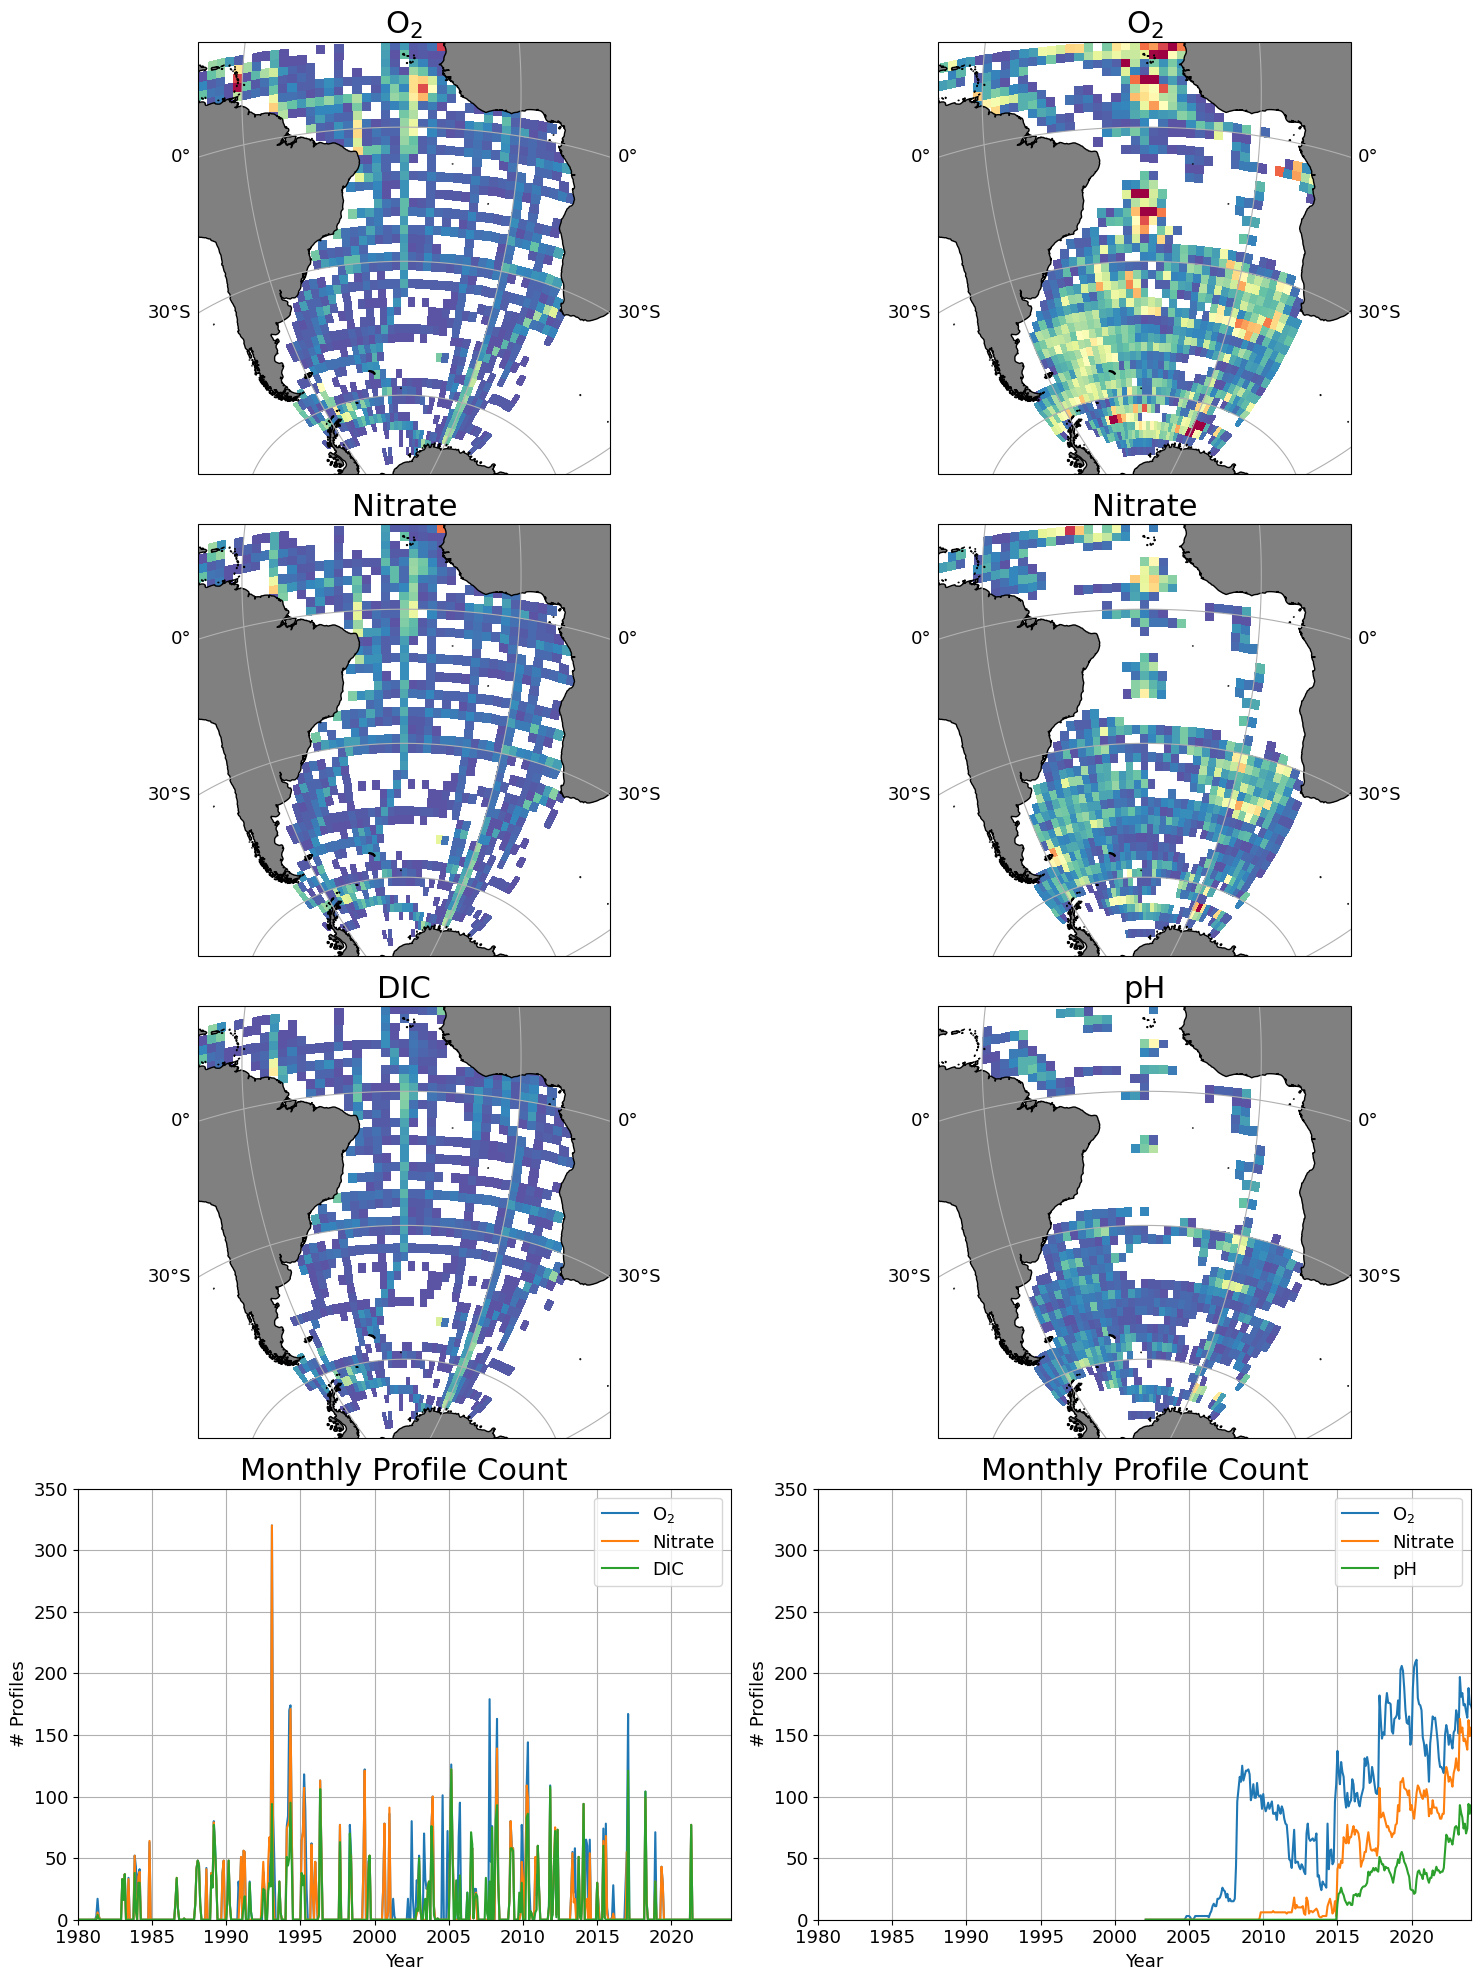

In [113]:
fig = plt.figure(figsize=(15, 20))
var  = 'DOXY_ADJUSTED'
title_font_size = 22
axis_label_font_size = 18
plt.rcParams.update({'font.size': 13})
# Create a grid of subplots using gridspec
# gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[2, 2, 1])
var_names = ['O$_2$', 'Nitrate', 'pH']
gdap_var_names = ['O$_2$', 'Nitrate', 'DIC']
for n, var in enumerate(var_select):
    if basin_select == 'Global':
        ax = fig.add_subplot(4,2,n*2+2, projection=ccrs.InterruptedGoodeHomolosine(central_longitude=-160, globe=None, emphasis='ocean'))
    else: # for non-global plots use a projection better suited to an individual basin:
        # Lambert Azimuthal Equal Area centered on the basin
        central_lon = (lon_lims[0] + lon_lims[1]) / 2
        central_lat = (lat_lims[0] + lat_lims[1]) / 2
        ax = fig.add_subplot(4,2,n*2+2, projection=ccrs.LambertAzimuthalEqualArea(
            central_longitude=central_lon, central_latitude=central_lat))
    # cmap = plt.cm.get_cmap("Spectrl_r", 64)
    # ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor=[.5, .5 ,.5]))

    ax.set_global()
    gl = ax.gridlines(draw_labels=True, ylocs=[-60, -30, 0, 30, 60], xlocs=[-180, -120, -60, 0, 60, 120], x_inline=False)
    gl.left_labels = True
    gl.top_labels = False
    gl.bottom_labels=False
    
    dlatlon = 2
    lonbins = np.arange(-180, 180, dlatlon)
    latbins = np.arange(-80, 80, dlatlon)

    hist = stats.binned_statistic_2d(argo_all[var].LATITUDE, argo_all[var].LONGITUDE, None, bins=[latbins, lonbins], statistic="count")
    hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
    hist.statistic

    image = plt.pcolormesh(lonbins, latbins, hist.statistic, cmap='Spectral_r', shading="flat", transform=ccrs.PlateCarree()) 
    plt.clim(0, 100) 
    if basin_select != 'Global':
        ax.set_extent([lon_lims[0], lon_lims[1], lat_lims[0], lat_lims[1]], crs=ccrs.PlateCarree())
    
    plt.title(var_names[n], loc='center', size=title_font_size)
    
    # Store the mappable for the shared colorbar (use the last one)
    if n == len(var_select) - 1:
        argo_mappable = image

for n, var in enumerate(gdap_var_select):
    if basin_select == 'Global':
        ax = fig.add_subplot(4,2,n*2+1, projection=ccrs.InterruptedGoodeHomolosine(central_longitude=-160, globe=None, emphasis='ocean'))
    else: # for non-global plots use a projection better suited to an individual basin:
        # Lambert Azimuthal Equal Area centered on the basin
        central_lon = (lon_lims[0] + lon_lims[1]) / 2
        central_lat = (lat_lims[0] + lat_lims[1]) / 2
        ax = fig.add_subplot(4,2,n*2+1, projection=ccrs.LambertAzimuthalEqualArea(
            central_longitude=central_lon, central_latitude=central_lat))
    # cmap = plt.cm.get_cmap("Spectrl_r", 64)
    # ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor=[.5, .5 ,.5]))

    ax.set_global()
    gl = ax.gridlines(draw_labels=True, ylocs=[-60, -30, 0, 30, 60], xlocs=[-180, -120, -60, 0, 60, 120], x_inline=False)
    gl.left_labels = True
    gl.top_labels = False
    gl.bottom_labels=False
    
    dlatlon = 2
    lonbins = np.arange(-180, 180, dlatlon)
    latbins = np.arange(-80, 80, dlatlon)

    hist = stats.binned_statistic_2d(gdap_all[var].LATITUDE, gdap_all[var].LONGITUDE, None, bins=[latbins, lonbins], statistic="count")
    hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
    hist.statistic

    image = plt.pcolormesh(lonbins, latbins, hist.statistic, cmap='Spectral_r', shading="flat", transform=ccrs.PlateCarree()) 
    plt.clim(0, 100) 
    if basin_select != 'Global':
        ax.set_extent([lon_lims[0], lon_lims[1], lat_lims[0], lat_lims[1]], crs=ccrs.PlateCarree())
    
    plt.title(gdap_var_names[n], loc='center', size=title_font_size)
    
    # Store the mappable for the shared colorbar (use the last one)
    if n == len(gdap_var_select) - 1:
        gdap_mappable = image

# Add shared colorbars
# Get all the map subplot axes for each dataset
argo_axes = [fig.axes[i] for i in [1, 3, 5]]  # Argo subplots (right column)
gdap_axes = [fig.axes[i] for i in [0, 2, 4]]  # GLODAP subplots (left column)

# # Create shared colorbar for GLODAP plots (left side)
# cbar_gdap = fig.colorbar(gdap_mappable, ax=gdap_axes, orientation='vertical', 
#                          shrink=0.8, aspect=30, pad=0.02)
# cbar_gdap.ax.tick_params(labelsize=10)
# cbar_gdap.set_label(label='GLODAP Profiles', size=axis_label_font_size)

# Create colorbar for Argo plots (use the middle subplot as reference)
# divider_argo = make_axes_locatable(argo_axes[1])  # Use middle Argo subplot
# cax_argo = divider_argo.append_axes("right", size="5%", pad=0.1)
# cbar_argo = plt.colorbar(argo_mappable, cax=cax_argo, orientation='vertical')
# cbar_argo.ax.tick_params(labelsize=10)
# cbar_argo.set_label(label='Argo Profiles', size=axis_label_font_size)

ax = fig.add_subplot(4,2,7)
plt.plot(gdap_year_month_profile_count['decimal_year'].values, gdap_year_month_profile_count['O2 Profiles'].values, label=var_names[0])
plt.plot(gdap_year_month_profile_count['decimal_year'].values, gdap_year_month_profile_count['Nitrate Profiles'].values, label=var_names[1] )
plt.plot(gdap_year_month_profile_count['decimal_year'].values, gdap_year_month_profile_count['DIC Profiles'].values, label='DIC')
plt.legend()
ax.set_ylabel('# Profiles')
ax.set_xlim(1980, 2024)
ax.set_ylim(0, 350)
ax.grid('on')
ax.set_xlabel('Year')
ax.set_title('Monthly Profile Count', loc='center', size=title_font_size)


ax = fig.add_subplot(4,2,8)
plt.plot(year_month_profile_count['decimal_year'].values, year_month_profile_count['O2 Profiles'].values, label=var_names[0])
plt.plot(year_month_profile_count['decimal_year'].values, year_month_profile_count['Nitrate Profiles'].values, label=var_names[1] )
plt.plot(year_month_profile_count['decimal_year'].values, year_month_profile_count['pH Profiles'].values, label=var_names[2])
plt.legend()
ax.set_ylabel('# Profiles')
ax.set_xlabel('Year')
ax.set_ylim(0, 350)
ax.set_xlim(1980, 2024)
ax.grid('on')

ax.set_title('Monthly Profile Count', loc='center', size=title_font_size)

plt.tight_layout()

plt.savefig(figure_dir+ 'Argo_GDAC_Sampling_Density and num_profiles_' + plot_ver + '.pdf', dpi = 300)